# Facial Keypoint Detection and Real-time Filtering

---

Build an end-to-end facial keypoint recognition system using computer vision techniques and deep learning. Facial keypoints include points around the eyes, nose, and mouth on any face and are used in many applications, from facial tracking to emotion recognition. The system can take in any image or video containing faces and identify the location of each face and their facial keypoints. The system can also do filtering on an image or video and put sunglasses above the eyes. 

The project is divided into four main parts, some of which may contain more than one step:

**Part 1**: Investigating OpenCV, pre-processing, and face detection

* [Step 0](#step0): Detect Faces Using a Haar Cascade Classifier
* [Step 1](#step1): Add Eye Detection
* [Step 2](#step2): De-noise an Image for Better Face Detection
* [Step 3](#step3): Blur an Image and Perform Edge Detection
* [Step 4](#step4): Automatically Hide the Identity of an Individual

**Part 2**: Training a Convolutional Neural Network (CNN) to detect facial keypoints

* [Step 5](#step5): Create a CNN to Recognize Facial Keypoints
* [Step 6](#step6): Compile and Train the Model
* [Step 7](#step7): Discuss Network Architecture and Visualize the Loss and Test Predictions

**Part 3**: Putting parts 1 and 2 together to identify facial keypoints on any image or video

* [Step 8](#step8): Build a Robust Facial Keypoints Detector (Complete the CV Pipeline)

**Part 4**: Adding a filter using facial keypoints to an image and video

* [Step 9](#step9): Add a Filter Using Facial Keypoints

---
<a id='step0'></a>
## Step 0: Detect Faces Using a Haar Cascade Classifier

At its root face detection is a classification problem - that is a problem of distinguishing between distinct classes of things.  With face detection these distinct classes are 1) images of human faces and 2) everything else. 

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  Some of these detectors have been downloaded and stored in the `detector_architectures` subdirectory.


In the next python cell, we load in the required libraries for this section of the project.

In [1]:
# Import required libraries for this section
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
# OpenCV library for computer vision
import cv2
from PIL import Image
import time
from keras.models import load_model

/home/trang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Next, we load in and display a test image for performing face detection.

*Note*: by default OpenCV assumes the ordering of our image's color channels are Blue, then Green, then Red.  This is slightly out of order with most image types we'll use in these experiments, whose color channels are ordered Red, then Green, then Blue.  In order to switch the Blue and Red channels of our test image around we will use OpenCV's `cvtColor` function (for more information, [check out some of its documentation located here](http://docs.opencv.org/3.2.0/df/d9d/tutorial_py_colorspaces.html)).  This is a general utility function that can do other transformations too like converting a color image to grayscale, and transforming a standard color image to HSV color space.

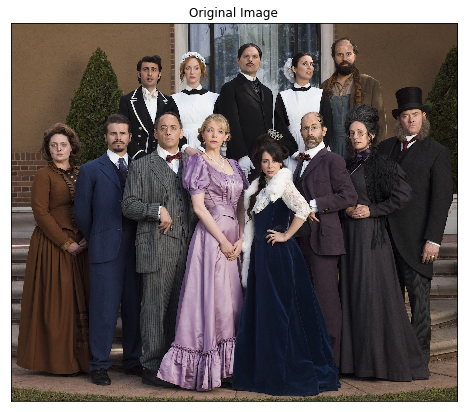

In [2]:
# Load in color image for face detection
image = cv2.imread('images/test_image_1.jpg')

# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot our image using subplots to specify a size and title
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Original Image')
ax1.imshow(image)

There are a lot of people - and faces - in this picture.  13 faces to be exact!  In the next code cell, we demonstrate how to use a Haar Cascade classifier to detect all the faces in this test image.

This face detector uses information about patterns of intensity in an image to reliably detect faces under varying light conditions. So, to use this face detector, we'll first convert the image from color to grayscale. 

Then, we load in the fully trained architecture of the face detector -- found in the file *haarcascade_frontalface_default.xml* - and use it on our image to find faces! 

To learn more about the parameters of the detector see [this post](https://stackoverflow.com/questions/20801015/recommended-values-for-opencv-detectmultiscale-parameters).

Number of faces detected: 13


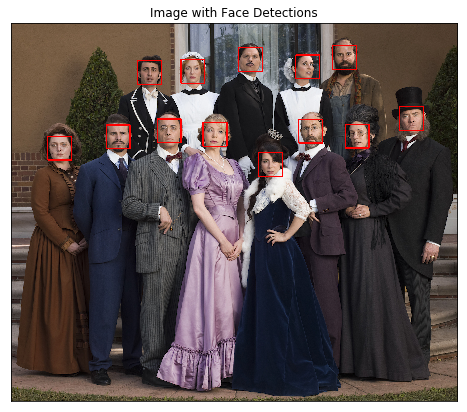

In [3]:
# Convert the RGB  image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Extract the pre-trained face detector from an xml file
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# Detect the faces in image
faces = face_cascade.detectMultiScale(gray, scaleFactor=4, minNeighbors=6)

# Print the number of faces detected in the image
print('Number of faces detected:', len(faces))

# Make a copy of the orginal image to draw face detections on
image_with_detections = np.copy(image)

# Get the bounding box for each detected face
for (x,y,w,h) in faces:
    # Add a red bounding box to the detections image
    cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), 3)
    

# Display the image with the detections
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Image with Face Detections')
ax1.imshow(image_with_detections)

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

---
<a id='step1'></a>

## Step 1: Add Eye Detections

There are other pre-trained detectors available that use a Haar Cascade Classifier - including full human body detectors, license plate detectors, and more.  [A full list of the pre-trained architectures can be found here](https://github.com/opencv/opencv/tree/master/data/haarcascades). 

### Detect a single face
To test our eye detector, we'll first read in a new test image with just a single face.

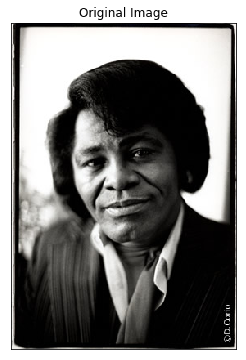

In [4]:
# Load in color image for face detection
image = cv2.imread('images/james.jpg')

# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the RGB image
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Original Image')
ax1.imshow(image)

Notice that even though the image is a black and white image, we have read it in as a color image and so it will still need to be converted to grayscale in order to perform the most accurate face detection.

So, the next steps will be to convert this image to grayscale, then load OpenCV's face detector and run it with parameters that detect this face accurately.

Number of faces detected: 1


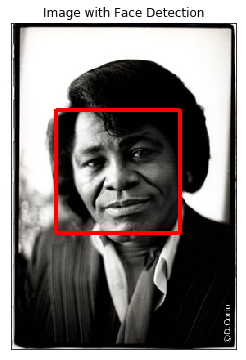

In [5]:
# Convert the RGB  image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Extract the pre-trained face detector from an xml file
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# Detect the faces in image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.25, minNeighbors=6)

# Print the number of faces detected in the image
print('Number of faces detected:', len(faces))

# Make a copy of the orginal image to draw face detections on
image_with_detections = np.copy(image)

# Get the bounding box for each detected face
for (x,y,w,h) in faces:
    # Add a red bounding box to the detections image
    cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), 3)
    
# Display the image with the detections
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Image with Face Detection')
ax1.imshow(image_with_detections)

### Add an eye detector to the current face detection setup

A Haar-cascade eye detector can be included in the same way that the face detector was. To set up an eye detector, we will use the stored parameters of the eye cascade detector, called `haarcascade_eye.xml`, located in the `detector_architectures` subdirectory. In the next code cell, we will create an eye detector and store its detections.

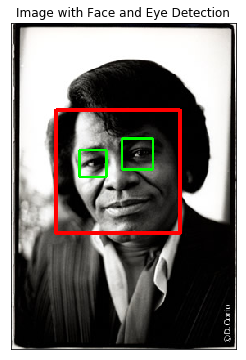

In [6]:
# Make a copy of the original image to plot rectangle detections
image_with_detections = np.copy(image)   

# Loop over the detections and draw their corresponding face detection boxes
for (x,y,w,h) in faces:
    cv2.rectangle(image_with_detections, (x,y), (x+w,y+h),(255,0,0), 3)  
    
# Add eye detection, using haarcascade_eye.xml, to the current face detector algorithm
eye_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_eye.xml')
# Loop over the eye detections and draw their corresponding boxes in green on image_with_detections.
# Note: Since we've already run the face detector over this image, we should only search for eyes 
# within the rectangular face regions detected in faces. This will minimize false detections.
for (x,y,w,h) in faces:
    eyes = eye_cascade.detectMultiScale(gray[y:y+h, x:x+w])
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(image_with_detections[y:y+h, x:x+w],(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

# Plot the image with both faces and eyes detected
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Image with Face and Eye Detection')
ax1.imshow(image_with_detections)

### Add face and eye detection to a laptop camera

Next, we will add face and eye detection to a laptop's camera. The next cell contains code for a wrapper function called `laptop_camera_face_eye_detector` that, when called, will activate the camera of a laptop used to run this notebook. Here an gif image of what I got when running the code on my laptop.

<img src="images/laptop_face_detector_example.gif" width=400 height=300/>

>**Note:** Mac users may find that activating this function kills the kernel of their notebook every once in a while.  If this happens to you, just restart your notebook's kernel, activate cell(s) containing any crucial import statements, and you'll be good to go!

>When you want to close the camera window, **press any key to close it**

In [7]:
def laptop_camera_face_eye_detector():
    """Wrapper function for face/eye detection with a laptop camera."""
    
    # Create instance of video capturer
    cv2.namedWindow("face detection activated")
    vc = cv2.VideoCapture(0)

    # Try to get the first frame
    if vc.isOpened(): 
        rval, frame = vc.read()
    else:
        rval = False

    # Keep the video stream open
    while rval:
        # Detect face(s)
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=6)
        for (x,y,w,h) in faces:
            cv2.rectangle(frame, (x,y), (x+w,y+h), (255,0,0), 3)
        
        # Detect eyes
        eye_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_eye.xml')
        for (x,y,w,h) in faces:
            eyes = eye_cascade.detectMultiScale(gray[y:y+h, x:x+w], scaleFactor=1.25, minNeighbors=8)
            for (ex,ey,ew,eh) in eyes:
                cv2.rectangle(frame[y:y+h, x:x+w],(ex,ey),(ex+ew,ey+eh),(0,255,0), 2)

        # Plot the image from camera with all the face and eye detections marked
        cv2.imshow("face detection activated", frame)
        
        # Exit functionality - press any key to exit laptop video
        key = cv2.waitKey(20)
        if key > 0: # Exit by pressing any key
            # Destroy windows 
            cv2.destroyAllWindows()
            
            # Make sure window closes on OSx
            for i in range (1,5):
                cv2.waitKey(1)
            return
        
        # Read next frame
        time.sleep(0.05)             # control framerate for computation - default 20 frames per sec
        rval, frame = vc.read()    

In [22]:
# Call the laptop camera face/eye detector function above
# Press any key to close the camera window
laptop_camera_face_eye_detector()

---
<a id='step2'></a>

## Step 2: De-noise an Image for Better Face Detection

Image quality is an important aspect of any computer vision task. Typically, when creating a set of images to train a deep learning network, significant care is taken to ensure that training images are free of visual noise or artifacts that hinder object detection. While computer vision algorithms - like a face detector - are typically trained on 'nice' data such as this, new test data doesn't always look so nice!

Before applying a trained computer vision algorithm to a new piece of data, we need to *pre-processes* it. This process can include a number of cleaning phases like blurring, de-noising, color transformations, etc., and many of these tasks can be accomplished using OpenCV.

We will explore OpenCV's noise-removal functionality to see how we can clean up a noisy image, which we then feed into our trained face detector.

### Create a noisy image to work with

In the next cell, we create an artificial noisy version of the previous multi-face image.  This is a little exaggerated - we don't typically get images that are this noisy - but [image noise](https://digital-photography-school.com/how-to-avoid-and-reduce-noise-in-your-images/), or 'grainy-ness' in a digitial image - is a fairly common phenomenon.

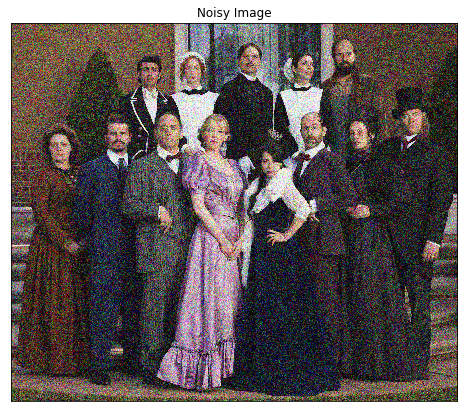

In [9]:
# Load in the multi-face test image again
image = cv2.imread('images/test_image_1.jpg')

# Convert the image copy to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Make an array copy of this image
image_with_noise = np.asarray(image)

# Create noise - here we add noise sampled randomly from a Gaussian distribution: a common model for noise
noise_level = 40
noise = np.random.randn(image.shape[0],image.shape[1],image.shape[2])*noise_level

# Add this noise to the array image copy
image_with_noise = image_with_noise + noise

# Convert back to uint8 format
image_with_noise = np.asarray([np.uint8(np.clip(i,0,255)) for i in image_with_noise])

# Plot our noisy image!
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Noisy Image')
ax1.imshow(image_with_noise)

In the context of face detection, the problem with an image like this is that  - due to noise - we may miss some faces or get false detections.  

In the next cell we apply the same trained OpenCV detector with the same settings as before, to see what sort of detections we get.

Number of faces detected: 10


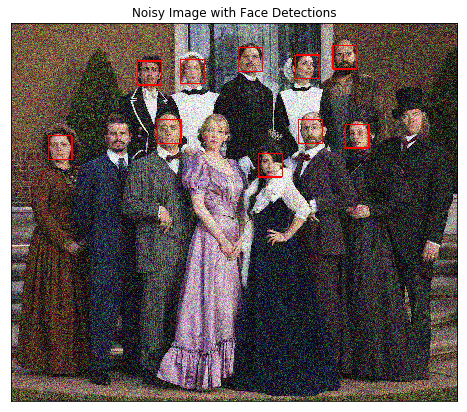

In [10]:
# Convert the RGB image to grayscale
gray_noise = cv2.cvtColor(image_with_noise, cv2.COLOR_RGB2GRAY)

# Extract the pre-trained face detector from an xml file
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# Detect the faces in image
faces = face_cascade.detectMultiScale(gray_noise, scaleFactor=4, minNeighbors=8)

# Print the number of faces detected in the image
print('Number of faces detected:', len(faces))

# Make a copy of the orginal image to draw face detections on
image_with_detections = np.copy(image_with_noise)

# Get the bounding box for each detected face
for (x,y,w,h) in faces:
    # Add a red bounding box to the detections image
    cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), 3)
    
# Display the image with the detections
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Noisy Image with Face Detections')
ax1.imshow(image_with_detections)

With this added noise we now miss some of the faces!

### De-noise this image for better face detection

We will use OpenCV's built in color image de-noising functionality called `fastNlMeansDenoisingColored` to de-noise this image enough so that all the faces in the image are properly detected. See its [official documentation here](http://docs.opencv.org/trunk/d1/d79/group__photo__denoise.html#ga21abc1c8b0e15f78cd3eff672cb6c476) and [a useful example here](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_photo/py_non_local_means/py_non_local_means.html).


We will keep all parameters *except* `photo_render` fixed as shown in the second link above. We'll play around with the value of this parameter and see how it affects the resulting cleaned image.

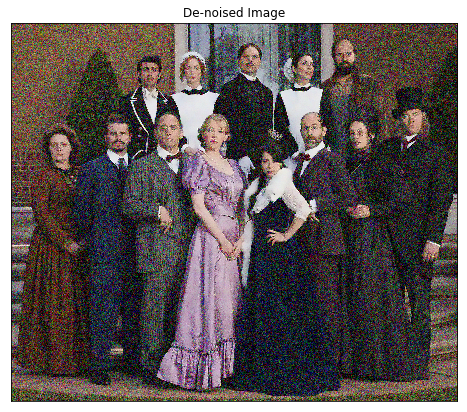

In [11]:
# Use OpenCV's built in color image de-noising function to clean up our noisy image
denoised_image = cv2.fastNlMeansDenoisingColored(image_with_noise,None,10,10,7,21)

fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('De-noised Image')
ax1.imshow(denoised_image)

Number of faces detected: 13


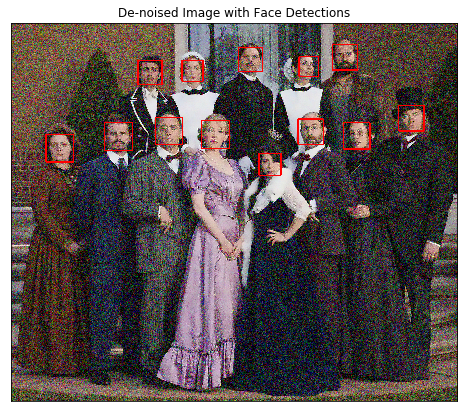

In [12]:
# Run the face detector on the de-noised image to improve our detections and display the result
# Convert the RGB  image to grayscale
gray_noise = cv2.cvtColor(denoised_image, cv2.COLOR_RGB2GRAY)

# Extract the pre-trained face detector from an xml file
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# Detect the faces in image
faces = face_cascade.detectMultiScale(gray_noise, scaleFactor=1.2, minNeighbors=6)

# Print the number of faces detected in the image
print('Number of faces detected:', len(faces))

# Make a copy of the orginal image to draw face detections on
image_with_detections = np.copy(denoised_image)

# Get the bounding box for each detected face
for (x,y,w,h) in faces:
    # Add a red bounding box to the detections image
    cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), 3)
    
# Display the image with the detections
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('De-noised Image with Face Detections')
ax1.imshow(image_with_detections)

---
<a id='step3'></a>

## Step 3: Blur an Image and Perform Edge Detection

Now that we have developed a simple pipeline for detecting faces using OpenCV - let's start playing around with a few fun things we can do with all those detected faces!

### Importance of blur in edge detection

Edge detection is a concept that pops up almost everywhere in computer vision applications, as edge-based features (as well as features built on top of edges) are often some of the best features for e.g., object detection and recognition problems.

Edge detection is a dimension reduction technique - by keeping only the edges of an image we get to throw away a lot of non-discriminating information. And typically the most useful kind of edge-detection is one that preserves only the important, global structures (ignoring local structures that aren't very discriminative). So removing local structures / retaining global structures is a crucial pre-processing step to performing edge detection in an image, and blurring can do just that.  

Below is an animated gif showing the result of an edge-detected cat [taken from Wikipedia](https://en.wikipedia.org/wiki/Gaussian_blur#Common_uses), where the image is gradually blurred more and more prior to edge detection. When the animation begins we can't quite make out what it's a picture of, but as the animation evolves and local structures are removed via blurring the cat becomes visible in the edge-detected image.

<img src="images/Edge_Image.gif" width=400 height=300/>

Edge detection is a **convolution** performed on the image itself.

### Canny edge detection

In the cell below we load in a test image, then apply [Canny edge detection](http://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html). on it.  The original image is shown on the left panel of the figure, while the edge-detected version of the image is shown on the right. The result looks very busy - there are too many little details preserved in the image before it is sent to the edge detector. When applied in computer vision applications, edge detection should preserve *global* structure; doing away with local structures that don't help describe what objects are in the image.

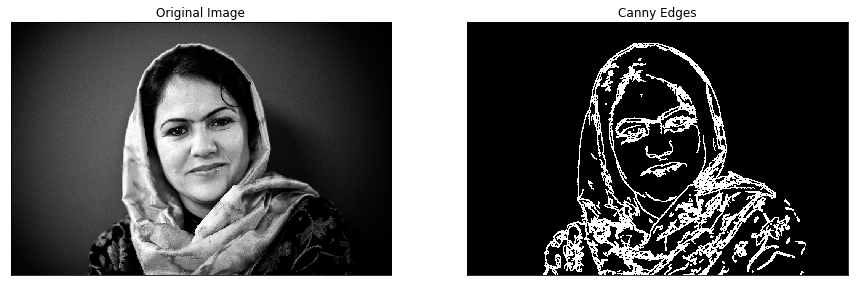

In [13]:
# Load in the image
image = cv2.imread('images/fawzia.jpg')

# Convert to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  

# Perform Canny edge detection
edges = cv2.Canny(gray,100,200)

# Dilate the image to amplify edges
edges = cv2.dilate(edges, None)

# Plot the RGB and edge-detected image
fig = plt.figure(figsize = (15,15))
ax1 = fig.add_subplot(121)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Original Image')
ax1.imshow(image)

ax2 = fig.add_subplot(122)
ax2.set_xticks([])
ax2.set_yticks([])

ax2.set_title('Canny Edges')
ax2.imshow(edges, cmap='gray')

Without first blurring the image, and removing small, local structures, a lot of irrelevant edge content gets picked up and amplified by the detector (as shown in the right panel above). 

### Blur the image *then* perform edge detection

In the next cell, we will repeat this experiment - blurring the image first to remove these local structures, so that only the important boundary details remain in the edge-detected image.

We will blur the image by using OpenCV's `filter2d` functionality - which is discussed in [this documentation page](http://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html) - and use an *averaging kernel* of width equal to 4.

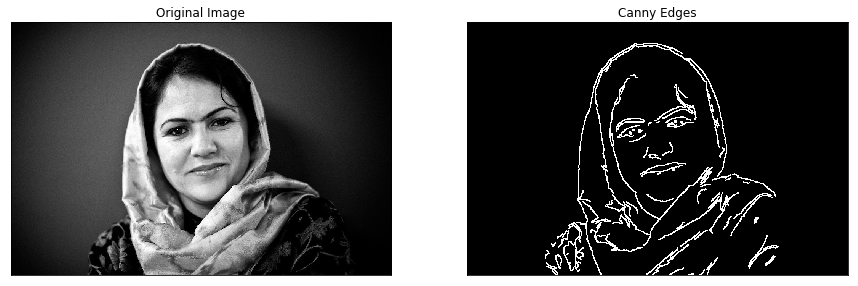

In [14]:
# Blur the test image using OpenCV's filter2d functionality, using an averaging kernel of width equal to 4
kernel = np.ones((4,4),np.float32)/16
blur_gray = cv2.filter2D(gray,-1,kernel)

# Perform Canny edge detection
edges = cv2.Canny(blur_gray,100,200)

# Dilate the image to amplify edges
edges = cv2.dilate(edges, None)

# Plot the RGB and edge-detected image
fig = plt.figure(figsize = (15,15))
ax1 = fig.add_subplot(121)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Original Image')
ax1.imshow(image)

ax2 = fig.add_subplot(122)
ax2.set_xticks([])
ax2.set_yticks([])

ax2.set_title('Canny Edges')
ax2.imshow(edges, cmap='gray')


---
<a id='step4'></a>

## Step 4: Automatically Hide the Identity of an Individual

An application of blurring the people's faces is to hide the identity of an individual as in projects like [Google's StreetView maps](https://www.google.com/streetview/) - an enormous collection of mapping images taken from a fleet of Google vehicles.  Because it would be impossible for Google to get the permission of every single person accidentally captured in one of these images they blur out everyone's faces, the detected images must automatically blur the identity of detected people.  Here's a few examples of folks caught in the camera of a Google street view vehicle.

<img src="images/streetview_example_1.jpg" width=400 height=300/>
<img src="images/streetview_example_2.jpg" width=400 height=300/>


We will use the face detection pipeline built above and the `filter2D` to blur an image, and use these in tandem to hide the identity of the person in the following image - loaded in and printed in the next cell. 

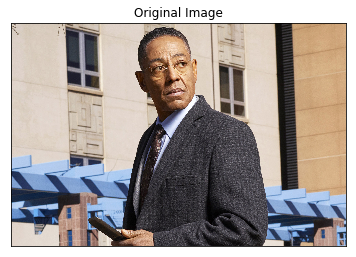

In [15]:
# Load in the image
image = cv2.imread('images/gus.jpg')

# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Original Image')
ax1.imshow(image)

### Use blurring to hide the identity of an individual in an image

The idea here is to 1) automatically detect the face in this image, and then 2) blur it out! We will adjust the parameters of the *averaging* blur filter to completely obscure this person's identity.

Number of faces detected: 1


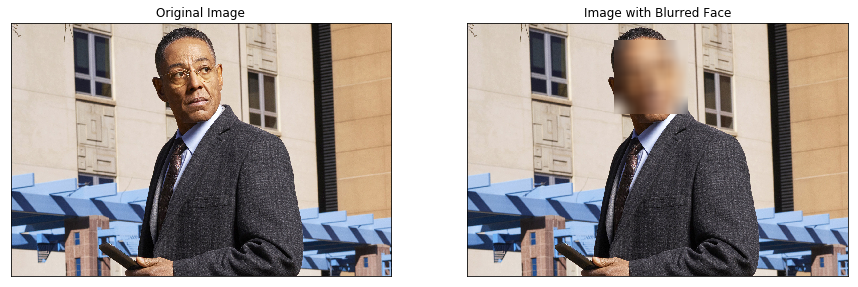

In [16]:
# Convert the RGB  image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Extract the pre-trained face detector from an xml file
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# Detect the faces in image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=6)

# Print the number of faces detected in the image
print('Number of faces detected:', len(faces))

# Use an averaging kernel, and a kernel width equal to 100
kernel = np.ones((100,100),np.float32)/10000

# Make a copy of the original image
image_with_blur_face = np.copy(image)

# Loop over the detections and blur the bounding box around each detected face
for (x,y,w,h) in faces:
    blur_face = cv2.filter2D(image[y:y+h, x:x+w],-1,kernel)
    image_with_blur_face[y:y+h, x:x+w] = blur_face

# Plot the RGB and the image with a blurred face
fig = plt.figure(figsize = (15,15))
ax1 = fig.add_subplot(121)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Original Image')
ax1.imshow(image)

ax2 = fig.add_subplot(122)
ax2.set_xticks([])
ax2.set_yticks([])

ax2.set_title('Image with Blurred Face')
ax2.imshow(image_with_blur_face, cmap='gray')

### Build identity protection into a laptop camera

Now we will add identity protection to a laptop camera. The next cell contains a wrapper function called `laptop_camera_identity_hider` that will activate the camera of the laptop running this notebook. Here is what I got when running the code on my laptop.

<img src="images/laptop_blurer_example.gif" width=400 height=300/>

>**Note:** Mac users may find that activating this function kills the kernel of their notebook every once in a while.  If this happens to you, just restart your notebook's kernel, activate cell(s) containing any crucial import statements, and you'll be good to go!

>When you want to close the camera window, **press any key to close it**.

In [17]:
def laptop_camera_identity_hider():
    """Wrapper function for hiding identity with a laptop camera."""
    # Create instance of video capturer
    cv2.namedWindow("face detection activated")
    vc = cv2.VideoCapture(0)

    # Try to get the first frame
    if vc.isOpened(): 
        rval, frame = vc.read()
    else:
        rval = False
    
    # Keep video stream open
    while rval:
        # Detect face(s)
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=6)
        kernel = np.ones((100,100),np.float32)/10000
        for (x,y,w,h) in faces:
            blur_face = cv2.filter2D(frame[y:y+h, x:x+w],-1,kernel)
            frame[y:y+h, x:x+w] = blur_face     
        
        # Plot image from camera with detections marked
        cv2.imshow("face detection activated", frame)
        
        # Exit functionality - press any key to exit laptop video
        key = cv2.waitKey(20)
        if key > 0: # Exit by pressing any key
            # Destroy windows
            cv2.destroyAllWindows()
            
            for i in range (1,5):
                cv2.waitKey(1)
            return
        
        # Read next frame
        time.sleep(0.05)             # control framerate for computation - default 20 frames per sec
        rval, frame = vc.read()    

In [18]:
# Run laptop identity hider
# Press any key to close the camera window
laptop_camera_identity_hider()

---
<a id='step5'></a>

## Step 5: Create a CNN to Recognize Facial Keypoints

We will create our own end-to-end pipeline - employing convolutional networks in Keras along with OpenCV - to apply a "selfie" filter to streaming video and images.  

We will start by creating and then training a convolutional network that can detect facial keypoints in a small dataset of cropped images of human faces. We will then use OpenCV to expand our detection algorithm to more general images. What are facial keypoints?  Let's take a look at some examples.

<img src="images/keypoints_test_results.png" width=400 height=300/>

Facial keypoints (also called facial landmarks) are the small blue-green dots shown on each of the faces in the image above - there are 15 keypoints marked in each image. They mark important areas of the face - the eyes, corners of the mouth, the nose, etc. Facial keypoints can be used in a variety of machine learning applications from face and emotion recognition to commercial applications like the image filters popularized by Snapchat.

### Make a facial keypoint detector

At a high level, facial keypoint detection is a *regression problem*. A single face corresponds to a set of 15 facial keypoints (a set of 15 corresponding $(x, y)$ coordinates, i.e., an output point). Because our input data are images, we can employ a *convolutional neural network* to recognize patterns in our images and learn how to identify these keypoints given sets of labeled data.

In order to train a regressor, we need a training set - a set of facial image / facial keypoint pairs to train on.  For this we will be using [this dataset from Kaggle](https://www.kaggle.com/c/facial-keypoints-detection/data). We've already downloaded this data and placed it in the `data` directory. The training dataset contains several thousand $96 \times 96$ grayscale images of cropped human faces, along with each face's 15 corresponding facial keypoints (also called landmarks) that have been placed by hand, and recorded in $(x, y)$ coordinates.  This wonderful resource also has a substantial testing set, which we will use in tinkering with our convolutional network.

To load in this data, we will run the Python cell below.

In [19]:
from utils import *

# Load training set
X_train, y_train = load_data()
print("X_train.shape == {}".format(X_train.shape))
print("y_train.shape == {}; y_train.min == {:.3f}; y_train.max == {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))

# Load testing set
X_test, _ = load_data(test=True)
print("X_test.shape == {}".format(X_test.shape))

/home/trang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


X_train.shape == (2140, 96, 96, 1)
y_train.shape == (2140, 30); y_train.min == -0.920; y_train.max == 0.996
X_test.shape == (1783, 96, 96, 1)


The `load_data` function in `utils.py` originates from this excellent [blog post](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/). The output values - that is, the coordinates of each set of facial landmarks - have been normalized to take on values in the range $[-1, 1]$, while the pixel values of each input point (a facial image) have been normalized to the range $[0,1]$.  

Note: the original Kaggle dataset contains some images with several missing keypoints.  For simplicity, the `load_data` function removes those images with missing labels from the dataset.

### Visualize the training data

We will visualize a subset of the training data using `plot_data` from `untils.py`.

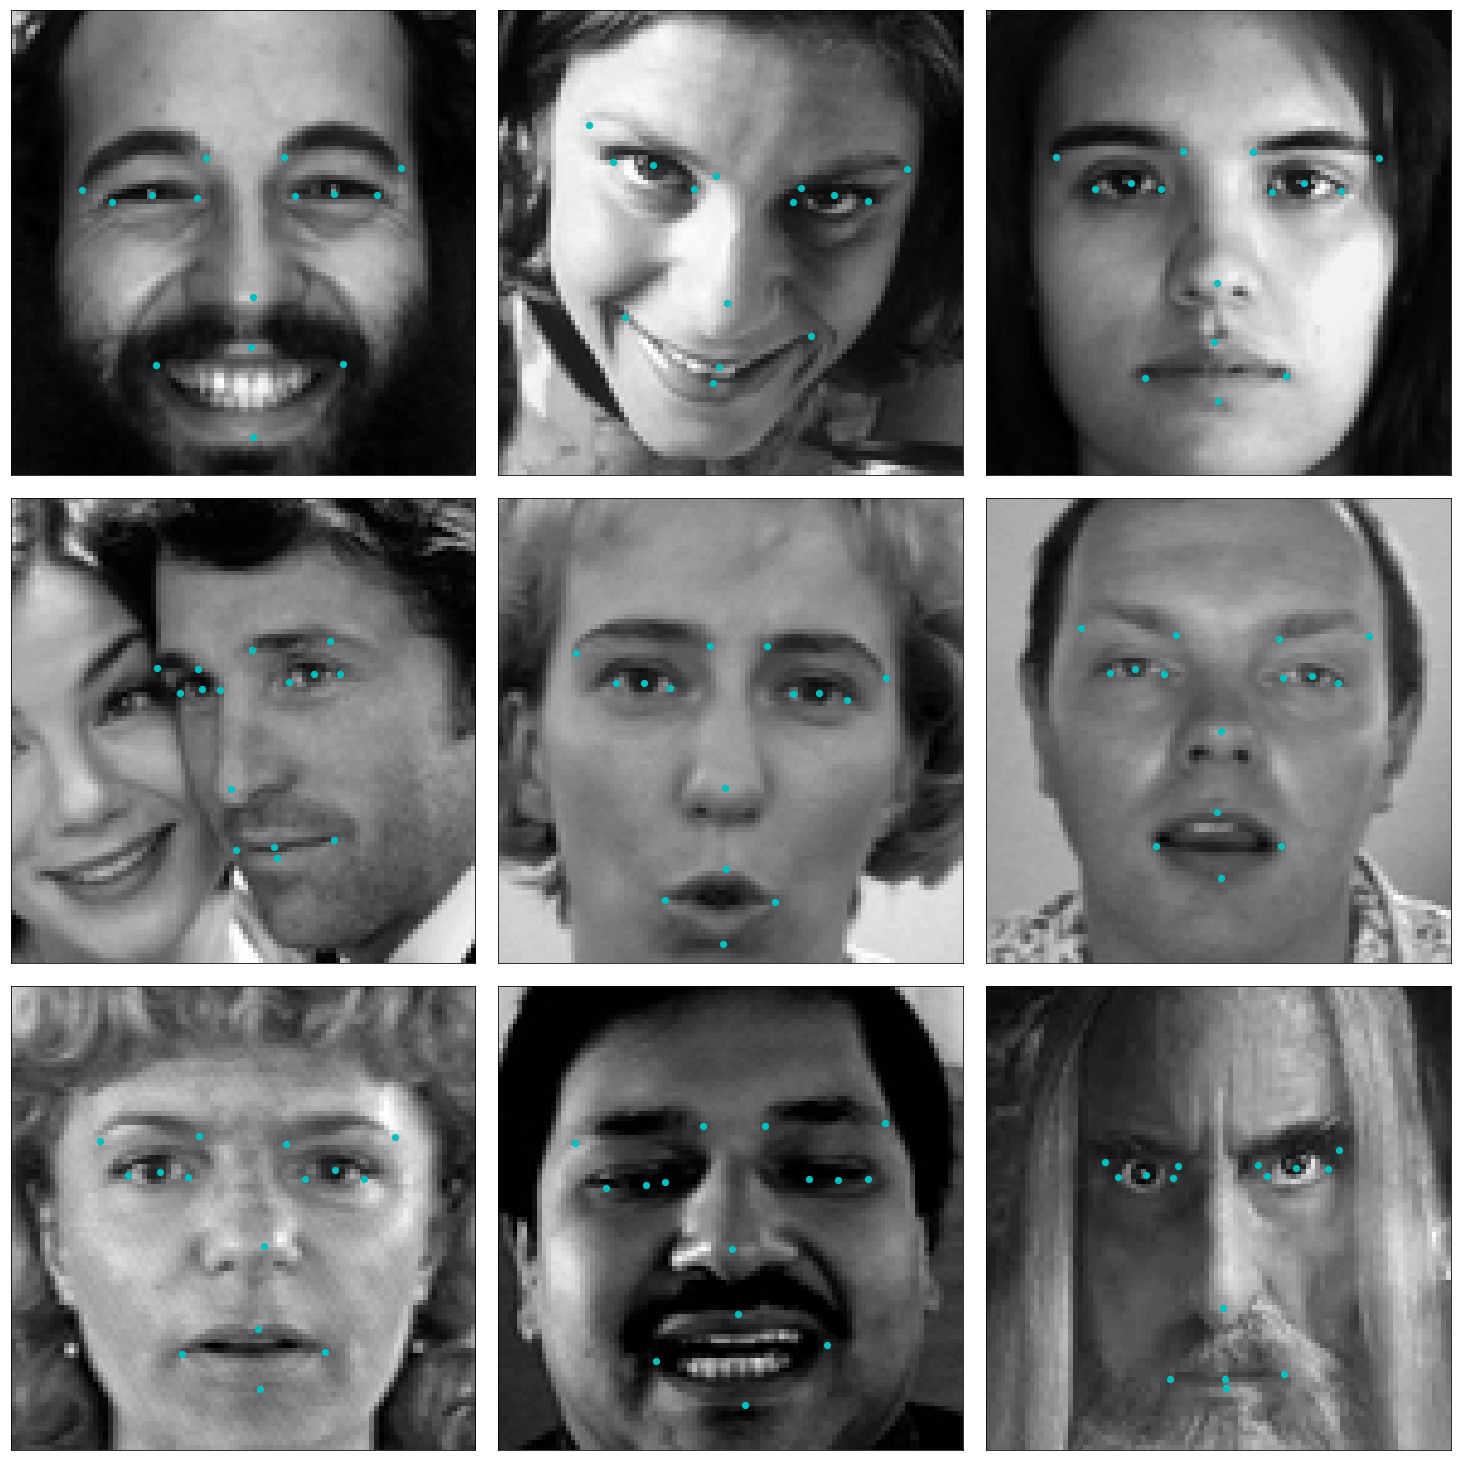

In [20]:
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X_train[i], y_train[i], ax)

For each training image, there are two landmarks per eyebrow (**four** total), three per eye (**six** total), **four** for the mouth, and **one** for the tip of the nose.

### Specify the CNN architecture

In this section, we will specify a neural network for predicting the locations of facial keypoints. It should accept a $96 \times 96$ grayscale image as input, and it should output a vector with 30 entries, corresponding to the predicted (horizontal and vertical) locations of 15 facial keypoints.

In [21]:
# Import deep learning resources from Keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.layers import Flatten, Dense

# Specify a CNN architecture which should accept 96x96 pixel graysale images in,
# and which should have a fully-connected output layer with 30 values (2 for each facial keypoint)
model = Sequential()
model.add(Convolution2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(96, 96, 1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Convolution2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Convolution2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(30))

# Summarize the model
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 16)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
con

---
<a id='step6'></a>

## Step 6: Compile and Train the Model

After specifying the architecture, we'll need to compile and train the model to detect facial keypoints.

### Compile and train the model

In [22]:
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Compile the model
model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
# Save the model as model.h5
checkpointer = ModelCheckpoint(filepath='my_model.h5', verbose=1, 
                               save_best_only=True)
# Stop training if the val_loss does not improve for 15 consecutive epochs
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto')
# Train the model; break off a validation set 
hist = model.fit(X_train, y_train, batch_size=32, epochs=200,
          validation_split=0.2, callbacks=[checkpointer, earlystopping], 
          verbose=2, shuffle=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 1712 samples, validate on 428 samples
Epoch 1/200
Epoch 00001: val_loss improved from inf to 0.10245, saving model to my_model.h5
 - 15s - loss: 0.4300 - mean_absolute_error: 0.2353 - val_loss: 0.1025 - val_mean_absolute_error: 0.2737
Epoch 2/200
Epoch 00002: val_loss improved from 0.10245 to 0.06440, saving model to my_model.h5
 - 13s - loss: 0.0335 - mean_absolute_error: 0.1422 - val_loss: 0.0644 - val_mean_absolute_error: 0.2139
Epoch 3/200
Epoch 00003: val_loss improved from 0.06440 to 0.01722, saving model to my_model.h5
 - 14s - loss: 0.0167 - mean_absolute_error: 0.0998 - val_loss: 0.0172 - val_mean_absolute_error: 0.1038
Epoch 4/200
Epoch 00004: val_loss improved from 0.01722 to 0.01235, saving model to my_model.h5
 - 14s - loss: 0.0111 - mean_absolute_error: 0.0803 - val_loss: 0.0123 - val_mean_absolute_error: 0.0872
Epoch 5/200
Epoch 00005: val_loss did not improve
 - 15s - loss: 0.0081 - mean_a

Epoch 45/200
Epoch 00045: val_loss improved from 0.00132 to 0.00125, saving model to my_model.h5
 - 14s - loss: 0.0014 - mean_absolute_error: 0.0274 - val_loss: 0.0012 - val_mean_absolute_error: 0.0247
Epoch 46/200
Epoch 00046: val_loss did not improve
 - 14s - loss: 0.0013 - mean_absolute_error: 0.0268 - val_loss: 0.0015 - val_mean_absolute_error: 0.0273
Epoch 47/200
Epoch 00047: val_loss did not improve
 - 14s - loss: 0.0013 - mean_absolute_error: 0.0269 - val_loss: 0.0014 - val_mean_absolute_error: 0.0260
Epoch 48/200
Epoch 00048: val_loss did not improve
 - 14s - loss: 0.0013 - mean_absolute_error: 0.0262 - val_loss: 0.0014 - val_mean_absolute_error: 0.0266
Epoch 49/200
Epoch 00049: val_loss did not improve
 - 14s - loss: 0.0013 - mean_absolute_error: 0.0262 - val_loss: 0.0015 - val_mean_absolute_error: 0.0275
Epoch 50/200
Epoch 00050: val_loss did not improve
 - 14s - loss: 0.0013 - mean_absolute_error: 0.0261 - val_loss: 0.0015 - val_mean_absolute_error: 0.0269
Epoch 51/200
Epoch

Epoch 93/200
Epoch 00093: val_loss improved from 0.00105 to 0.00102, saving model to my_model.h5
 - 16s - loss: 8.0508e-04 - mean_absolute_error: 0.0211 - val_loss: 0.0010 - val_mean_absolute_error: 0.0222
Epoch 94/200
Epoch 00094: val_loss did not improve
 - 14s - loss: 8.0069e-04 - mean_absolute_error: 0.0210 - val_loss: 0.0011 - val_mean_absolute_error: 0.0226
Epoch 95/200
Epoch 00095: val_loss did not improve
 - 15s - loss: 8.0367e-04 - mean_absolute_error: 0.0211 - val_loss: 0.0010 - val_mean_absolute_error: 0.0223
Epoch 96/200
Epoch 00096: val_loss did not improve
 - 14s - loss: 7.9005e-04 - mean_absolute_error: 0.0209 - val_loss: 0.0012 - val_mean_absolute_error: 0.0240
Epoch 97/200
Epoch 00097: val_loss did not improve
 - 14s - loss: 7.7995e-04 - mean_absolute_error: 0.0209 - val_loss: 0.0010 - val_mean_absolute_error: 0.0221
Epoch 98/200
Epoch 00098: val_loss did not improve
 - 14s - loss: 7.9201e-04 - mean_absolute_error: 0.0209 - val_loss: 0.0010 - val_mean_absolute_error: 0

---
<a id='step7'></a>

## Step 7: Discuss The Network Architecture and Visualize the Loss and Test Predictions

### Discuss the network architecture

**How I got to my final neural network architecture**

- The number of convolutional and max pooling layers: I experimented with 1, 2, 3, 4 and 5 pairs of convolutional and max pooling layers. Three convolutional and three max pooling layers produced the best result. Increasing the number of pairs of these layers beyond three didn't result in better performance but slowed down the training time.

- Kernel size: I tried 2, 3, 4 and 5. Higher sizes required more time for training but the validation loss didn't improve. Therefore I chose the kernel size of 2.

- Dropout: I found two things that worked well: (1) adding a dropout after each pair of convolutional and max pooling layers, and after the 2nd last fully-connected layer, and (2) increasing the dropout values as the network got deeper

- Batch size: I tried 3 values for batch size: 16, 32 and 64. A batch size of 16 produced the same result as that of 32 but the lower batch size slowed down the training time. Increasing the batch size to 64 resulted in a higher validation loss.


**How I chose an optimizer**

- I tried and evaluated all the available optimizers based on validation loss. SGD was not a good choice at all! RMSprop, Adam, Adagrad and Adamax were the best ones and produced similar results. I picked RMSprop.

###  Visualize the validation loss of the neural network

The code below plots the training and validation loss of the above model

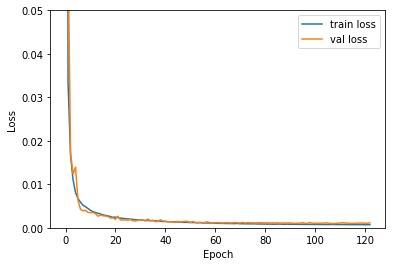

In [23]:
# Visualize the training and validation loss of the neural network
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,0.05))
plt.legend(['train loss', 'val loss'])
plt.show()

**Comments:** There was some evidence of overfitting before I used dropout. With the use of dropout, there is hardly any overfitting, as seen in the above graph.

### Visualize a subset of the test predictions

Now we will visualize the model's predicted keypoints on a subset of the testing images.

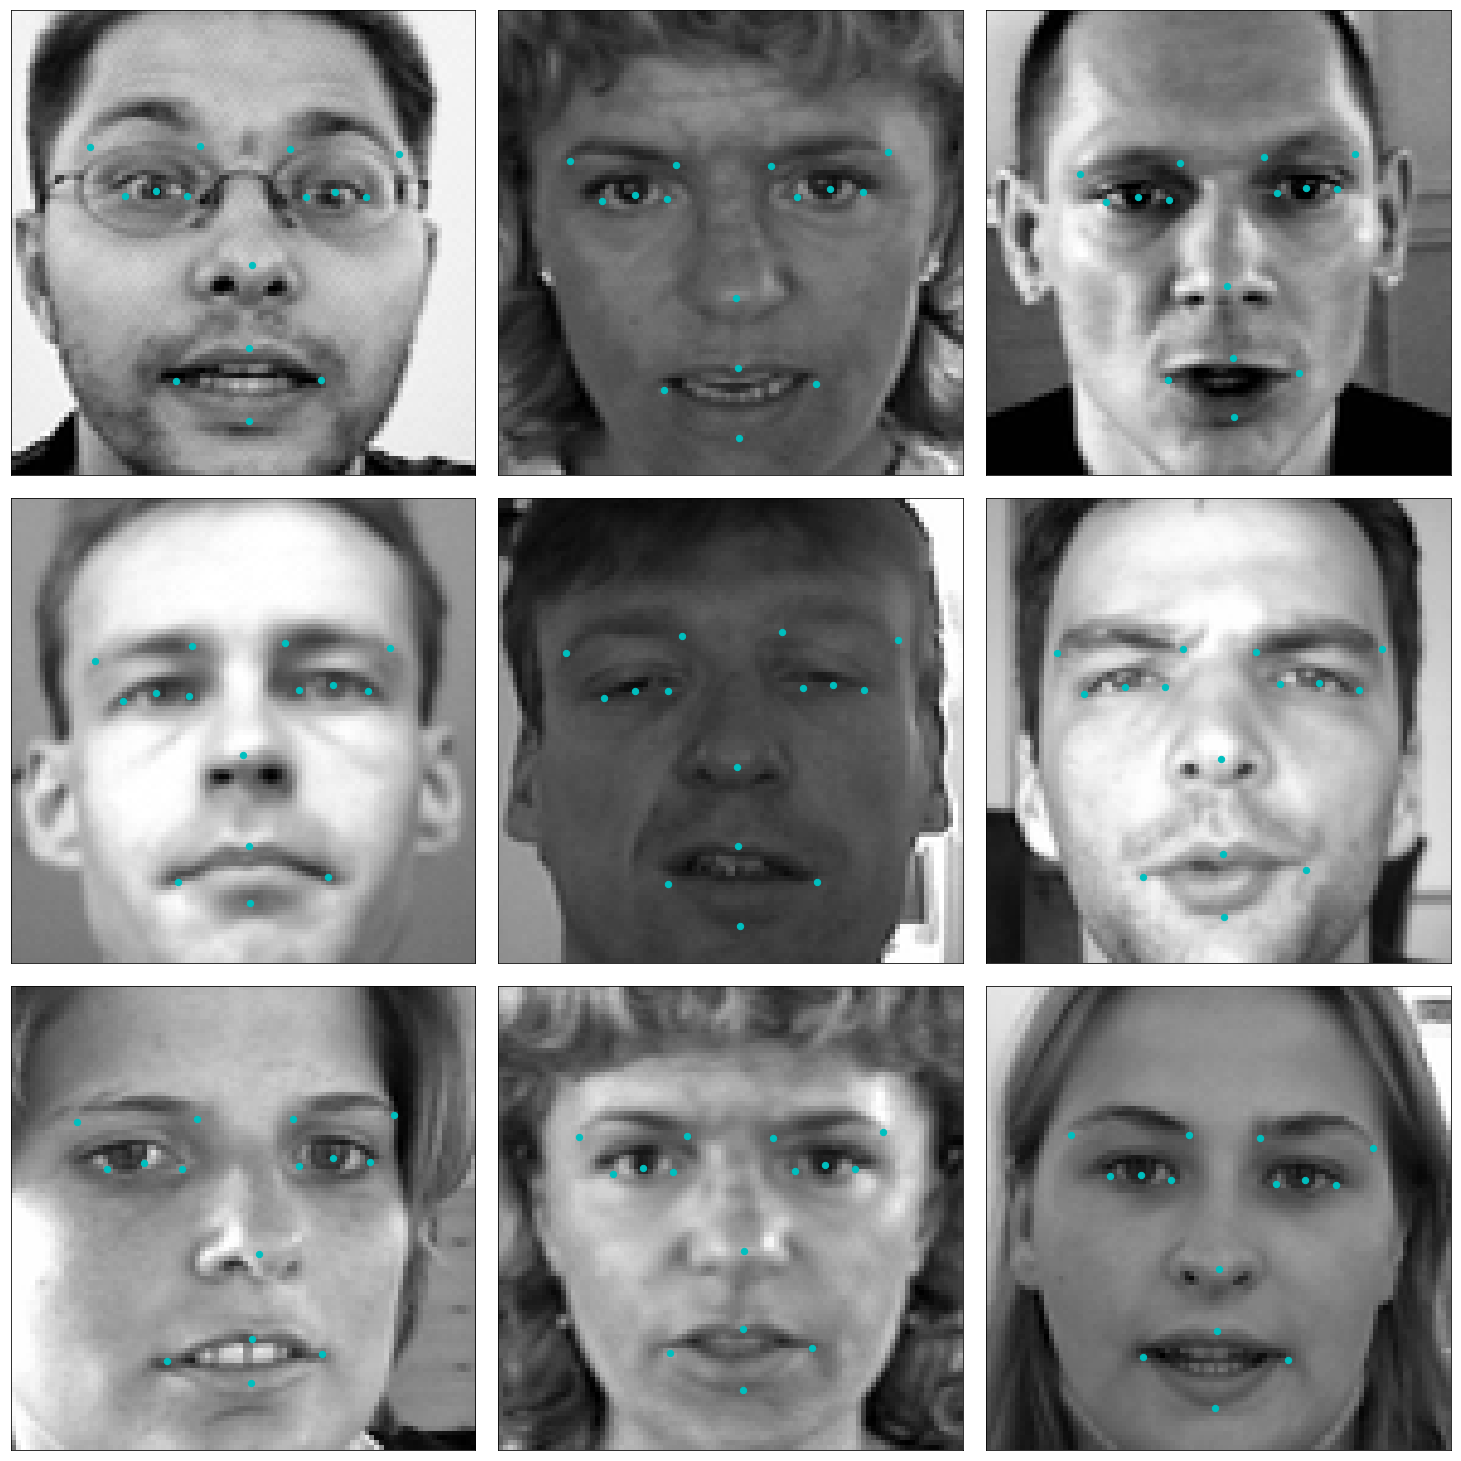

In [24]:
y_test = model.predict(X_test)
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X_test[i], y_test[i], ax)

---
<a id='step8'></a>

## Step 8: Build a Robust Facial Keypoints Detector

With the work we did in Sections 1 and 2 of this notebook, along with the freshly trained facial keypoint detector, we can now complete the full pipeline, i.e. given a color image containing a person or persons we can now 

- Detect the faces in this image automatically using OpenCV
- Predict the facial keypoints in each face detected in the image
- Paint predicted keypoints on each face detected

### Facial keypoints detector

Using the OpenCV face detection functionality built in previous Sections, we will expand the functionality of the keypoints detector to color images with arbitrary size. The function will perform the following steps

1. Accept a color image.
2. Convert the image to grayscale.
3. Detect and crop the face contained in the image.
4. Locate the facial keypoints in the cropped image.
5. Overlay the facial keypoints in the original (color, uncropped) image.

Step 4 can be the trickiest because our CNN is only trained to detect facial keypoints in $96 \times 96$ grayscale images where each pixel was normalized to lie in the interval $[0,1]$, and because each facial keypoint was normalized during training to the interval $[-1,1]$. This means to paint detected keypoints onto a test face we will need to perform this same pre-processing to the candidate face, which means:

* After detecting it we will need to resize it to $96 \times 96$ and normalize its pixel values to $[0,1]$ before feeding it into our facial keypoint detector. 
* To be shown correctly on the original image, the output keypoints from our detector then need to be shifted and re-normalized from the interval $[-1,1]$ to the width and height of the detected face.

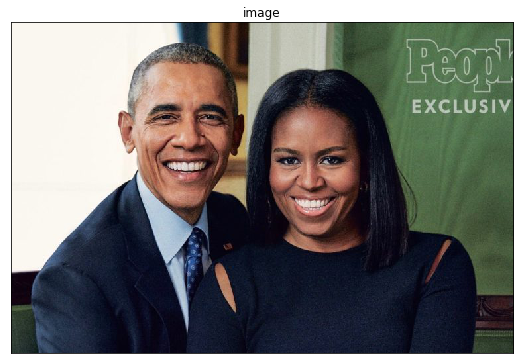

In [25]:
# Load in color image for face detection
image = cv2.imread('images/obamas4.jpg')
# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Plot our image
fig = plt.figure(figsize = (9,9))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('image')
ax1.imshow(image)

Number of faces detected: 2


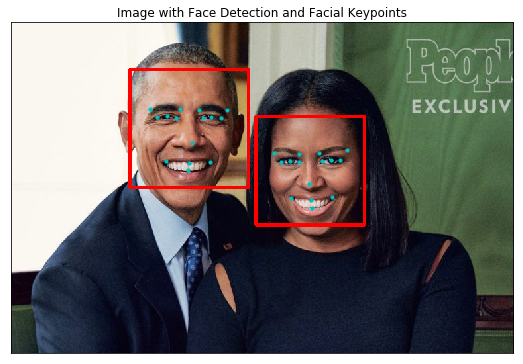

In [24]:
def plot_keypoints(img_path, face_cascade, model_path):
    """Use the face detection code from Section 1 with the trained CNN
    in order to paint the predicted keypoints on a given image."""
    
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Extract the pre-trained face detector from an xml file
    face_cascade = cv2.CascadeClassifier(face_cascade)

    # Detect the faces in image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=6)

    # Print the number of faces detected in the image
    print('Number of faces detected:', len(faces))

    # Make a copy of the original image to plot rectangle detections and facial keypoints
    image_with_detections = np.copy(image)   

    # Plot the image with both face detections
    fig = plt.figure(figsize = (9,9))
    ax1 = fig.add_subplot(111)
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax1.set_title('Image with Face Detection and Facial Keypoints')

    # Load the model we trained to detect facial keypoints
    model = load_model(model_path)

    # Loop over the detections and draw their corresponding face detection boxes
    for (x,y,w,h) in faces:
        cv2.rectangle(image_with_detections, (x,y), (x+w,y+h),(0,0,255), 3)
        bgr_crop = image_with_detections[y:y+h, x:x+w]
        orig_shape_crop = bgr_crop.shape
        gray_crop = cv2.cvtColor(bgr_crop, cv2.COLOR_BGR2GRAY)
        # Resize the detected face to 96×96 and normalize its pixel values to [0, 1]
        resize_gray_crop = cv2.resize(gray_crop, (96, 96)) / 255.
        # Predict the keypoints
        # Note: landmarks contains (x, y) locations of the 15 points: [x0, y0, x1, y1, x2, y2, etc.].
        landmarks = np.squeeze(model.predict(np.expand_dims(np.expand_dims(resize_gray_crop, axis=-1), axis=0)))
        # Get x and y coordinates for plotting and re-normalize the keypoints to their original dimensions
        # Note: landmarks[0::2] contains only x locations [x0, x1, x2, etc.], i.e. starting at the first index
        # and skipping every other index. Similarly, landmarks[1::2] is equivalent to [y0, y1, y2, etc.]
        x_values = ((landmarks[0::2] * 48 + 48)*orig_shape_crop[0]/96)+x
        y_values = ((landmarks[1::2] * 48 + 48)*orig_shape_crop[1]/96)+y
        ax1.scatter(x_values, y_values, marker='o', c='c', s=10)

    ax1.imshow(cv2.cvtColor(image_with_detections, cv2.COLOR_BGR2RGB))

# Detect the faces and plot facial keypoints for a given image
plot_keypoints(img_path='images/obamas4.jpg',
               face_cascade='detector_architectures/haarcascade_frontalface_default.xml', 
               model_path='my_model.h5')

### Add facial keypoint detection to a laptop camera

Now we can add facial keypoint detection to a laptop camera. The next Python cell contains the laptop video camera function which also includes facial keypoint detection and marking. I've also created `plot_keypoints_camera` to take in a video frame and draw the keypoints using `cv2.circle`. Here's a snapshot of what I got when running this code on my laptop (the code was running very slowly on my laptop so I couldn't capture an animated gif):

<img src="images/laptop_facial_keypoints.gif" width=400 height=300/>


>**Note:** Mac users may find that activating this function kills the kernel of their notebook every once in a while.  If this happens to you, just restart your notebook's kernel, activate cell(s) containing any crucial import statements, and you'll be good to go!

>When you want to close the camera window, **press any key to close it**.

In [54]:
def plot_keypoints_camera(frame, face_cascade, model_path):
    """Use the face detection code from Section 1 with the trained CNN
    in order to paint the predicted keypoints on a video frame."""
    
    # Detect face(s)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(face_cascade)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=6)    
    # Load the model we trained to detect facial keypoints
    model = load_model(model_path)
    # Draw face detection box(es) and facial keypoints
    for (x,y,w,h) in faces:
        cv2.rectangle(frame, (x,y), (x+w,y+h),(0,0,255), 3)
        bgr_crop = frame[y:y+h, x:x+w]
        orig_shape_crop = bgr_crop.shape
        gray_crop = cv2.cvtColor(bgr_crop, cv2.COLOR_BGR2GRAY)
        # Resize the detected face to 96×96 and normalize its values
        resize_gray_crop = cv2.resize(gray_crop, (96, 96)) / 255.
        # Predict the keypoints
        landmarks = np.squeeze(model.predict(np.expand_dims(np.expand_dims(resize_gray_crop, axis=-1), axis=0)))
        # Get x and y coordinates for plotting and re-normalize the keypoints to their original dimensions
        x_values = ((landmarks[0::2] * 48 + 48)*orig_shape_crop[0]/96)+x
        y_values = ((landmarks[1::2] * 48 + 48)*orig_shape_crop[1]/96)+y
        # Draw the facial keypoints whose center coordinates are x_values and y_values
        for i in range(len(x_values)):
            cv2.circle(frame, center=(x_values[i], y_values[i]), 
                       radius=3, color=(0, 255, 0), thickness=-1)

    cv2.imshow("face detection activated", frame)

def laptop_camera_keypoints():
    """Run a laptop's camera and plot facial keypoints."""
    # Create instance of video capturer
    cv2.namedWindow("face detection activated")
    vc = cv2.VideoCapture(0)

    # Try to get the first frame
    if vc.isOpened(): 
        rval, frame = vc.read()
    else:
        rval = False
    
    # keep video stream open
    while rval:
        # plot image from camera with detections marked
        plot_keypoints_camera(frame=frame,
               face_cascade='detector_architectures/haarcascade_frontalface_default.xml', 
               model_path='my_model.h5')

        # exit functionality - press any key to exit laptop video
        key = cv2.waitKey(20)
        if key > 0: # exit by pressing any key
            # destroy windows
            cv2.destroyAllWindows()
            
            # hack from stack overflow for making sure window closes on osx --> https://stackoverflow.com/questions/6116564/destroywindow-does-not-close-window-on-mac-using-python-and-opencv
            for i in range (1,5):
                cv2.waitKey(1)
            return
        
        # read next frame
        time.sleep(0.05)             # control framerate for computation - default 20 frames per sec
        rval, frame = vc.read()  

In [55]:
# Run the keypoint face painter
# Press any key to close the camera window
laptop_camera_keypoints()

---
<a id='step9'></a>
## Step 9: Add a Filter Using Facial Keypoints

Using the above facial keypoint detector pipeline we can now do things like add fun filters to a person's face automatically. In this we will play around with adding sunglasses automatically to each individual's face in an image as shown in a demonstration image below.

<img src="images/obamas_with_shades.png" width=1000 height=1000/>

To produce this effect, we will use an image of a pair of sunglasses shown in the Python cell below.

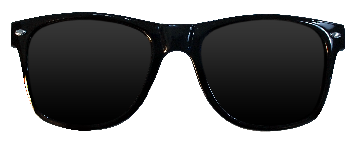

In [49]:
# Load in sunglasses image - note the usage of the special option
# cv2.IMREAD_UNCHANGED, this option is used because the sunglasses 
# image has a 4th channel that allows us to control how transparent each pixel in the image is
sunglasses = cv2.imread("images/sunglasses_4.png", cv2.IMREAD_UNCHANGED)

# Plot the image
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.imshow(sunglasses)
ax1.axis('off');

This image is placed over each individual's face using the detected eye points to determine the location of the sunglasses, and eyebrow points to determine the size that the sunglasses should be for each person (one could also use the nose point to determine this).  

Notice that this image actually has *4 channels*, not just 3. 

In [50]:
# Print out the shape of the sunglasses image
print ('The sunglasses image has shape: ' + str(np.shape(sunglasses)))

The sunglasses image has shape: (1123, 3064, 4)


It has the usual red, blue, and green channels any color image has, with the 4th channel representing the transparency level of each pixel in the image.  Here's how the transparency channel works: the lower the value, the more transparent the pixel will become.  The lower bound (completely transparent) is zero here, so any pixels set to 0 will not be seen. 

This is how we can place this image of sunglasses on someone's face and still see the area around of their face where the sunglasses lie - because these pixels in the sunglasses image have been made completely transparent.

Lets check out the alpha channel of our sunglasses image in the next Python cell.  Note because many of the pixels near the boundary are transparent we'll need to explicitly print out non-zero values if we want to see them. 

In [67]:
# Print out the sunglasses transparency (alpha) channel
alpha_channel = sunglasses[:,:,3]
print ('the alpha channel here looks like')
print (alpha_channel)

# Just to double check that there are indeed non-zero values
# Let's find and print out every value greater than zero
values = np.where(alpha_channel != 0)
print ('\n the non-zero values of the alpha channel look like')
print (values)

the alpha channel here looks like
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

 the non-zero values of the alpha channel look like
(array([  17,   17,   17, ..., 1109, 1109, 1109]), array([ 687,  688,  689, ..., 2376, 2377, 2378]))


This means that when we place this sunglasses image on top of another image, we can use the transparency channel as a filter to tell us which pixels to overlay on a new image (only the non-transparent ones with values greater than zero).

One last thing: it's helpful to understand which keypoint belongs to the eyes, mouth, etc. So, in the image below, we also display the index of each facial keypoint directly on the image.

<img src="images/obamas_points_numbered.png" width=500 height=500/>

With this information, let's complete this filtering task and place the sunglasses automatically on the individuals in the image loaded in / shown in the next Python cell.

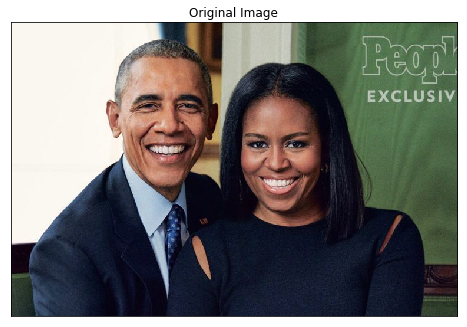

In [52]:
# Load in color image for face detection
image = cv2.imread('images/obamas4.jpg')
# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Plot the image
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Original Image')
ax1.imshow(image)

Number of faces detected: 2


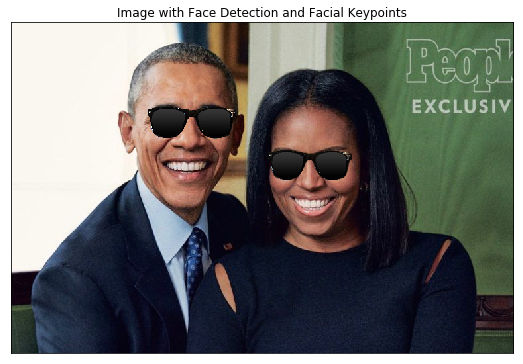

In [32]:
def filter_image(img_path, filter_path, face_cascade, model_path):
    """Use the face detection code from Section 1 with the trained CNN
    in order to put a filter image on another image."""
    
    image = cv2.imread(img_path)
    filter_img = cv2.imread(filter_path, cv2.IMREAD_UNCHANGED)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Extract the pre-trained face detector from an xml file
    face_cascade = cv2.CascadeClassifier(face_cascade)

    # Detect the faces in image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=6)

    # Print the number of faces detected in the image
    print('Number of faces detected:', len(faces))

    # Plot the image with both face detections
    fig = plt.figure(figsize = (9,9))
    ax1 = fig.add_subplot(111)
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax1.set_title('Image with Face Detection and Facial Keypoints')

    # Load the model we trained to detect facial keypoints
    model = load_model(model_path)

    # Loop over the detections and overlay filter_img onto image
    for (x,y,w,h) in faces:
        bgr_crop = image[y:y+h, x:x+w]
        orig_shape_crop = bgr_crop.shape
        gray_crop = cv2.cvtColor(bgr_crop, cv2.COLOR_BGR2GRAY)
        # Resize the detected face to 96×96 and normalize its pixel values to [0, 1]
        resize_gray_crop = cv2.resize(gray_crop, (96, 96)) / 255.
        # Predict the keypoints
        # Note: landmarks contains (x, y) locations of the 15 points: [x0, y0, x1, y1, x2, y2, etc.].
        landmarks = np.squeeze(model.predict(np.expand_dims(np.expand_dims(resize_gray_crop, axis=-1), axis=0)))
        # Get x and y coordinates and re-normalize the keypoints to their original dimensions
        # Note: landmarks[0::2] contains only x locations [x0, x1, x2, etc.], i.e. starting at the first index
        # and skipping every other index. Similarly, landmarks[1::2] is equivalent to [y0, y1, y2, etc.]
        x_values = ((landmarks[0::2] * 48 + 48)*orig_shape_crop[0]/96)+x
        y_values = ((landmarks[1::2] * 48 + 48)*orig_shape_crop[1]/96)+y
    
        # Calculate scale_factor to scale down the filter_img
        scale_factor = (x_values[7] - x_values[9])/filter_img.shape[1] * 1.15
        filter_img = cv2.resize(filter_img, dsize=(0, 0), fx=scale_factor, fy=scale_factor)
        # x1, x2, y1, and y2 are the leftmost x, rightmost x, top y and bottom y coordinates of the overlay area
        # Estimate x1 based on the nose position to make sure the filter_img is placed symmetrically on the face
        x1 = int(x_values[10] - filter_img.shape[1] / 2)
        x2 = x1 + filter_img.shape[1]
        # The highest point of filter_img is either end of an eyebrow; 
        # subtracting a few pixels to move filter_img up slightly
        y1 = int(max(y_values[8], y_values[9]) - 4)
        y2 = y1 + filter_img.shape[0]
        
        # Normalize the pixels of the alpha channel
        alpha_filter = filter_img[:, :, 3] / 255.0
        alpha_image = 1.0 - alpha_filter

        # Do filltering on each channel (R, G and B) of image
        for channel in range(image.shape[2]):
            image[y1:y2, x1:x2, channel] = alpha_filter * filter_img[:, :, channel] \
                                           + alpha_image * image[y1:y2, x1:x2, channel]

    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Put sunglasses on individuals in a given image
filter_image(img_path='images/obamas4.jpg', filter_path="images/sunglasses_4.png",
               face_cascade='detector_architectures/haarcascade_frontalface_default.xml', 
               model_path='my_model.h5')

### Add a filter using facial keypoints to a laptop camera 

Now we can add the sunglasses filter to a laptop camera - as illustrated in the gif below.

<img src="images/laptop_filterring.gif" width=400 height=300/>

The next Python cell contains the laptop video camera function that calls `filter_video` to put sunglasses on the face(s) detected in the camera. 

>**Note:** Mac users may find that activating this function kills the kernel of their notebook every once in a while.  If this happens to you, just restart your notebook's kernel, activate cell(s) containing any crucial import statements, and you'll be good to go!

>When you want to close the camera window, **press any key to close it**.

In [19]:
def filter_video(image, filter_path, face_cascade, model_path):
    """Use the face detection code from Section 1 with the trained CNN
    in order to put a filter image on the individual(s) in a laptop camera."""
    
    filter_img = cv2.imread(filter_path, cv2.IMREAD_UNCHANGED)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Extract the pre-trained face detector from an xml file
    face_cascade = cv2.CascadeClassifier(face_cascade)

    # Detect the faces in image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=6)

    # Load the model we trained to detect facial keypoints
    model = load_model(model_path)

    # Loop over the detections and overlay filter_img onto image
    for (x,y,w,h) in faces:
        bgr_crop = image[y:y+h, x:x+w]
        orig_shape_crop = bgr_crop.shape
        gray_crop = cv2.cvtColor(bgr_crop, cv2.COLOR_BGR2GRAY)
        # Resize the detected face to 96×96 and normalize its pixel values to [0, 1]
        resize_gray_crop = cv2.resize(gray_crop, (96, 96)) / 255.
        # Predict the keypoints
        # Note: landmarks contains (x, y) locations of the 15 points: [x0, y0, x1, y1, x2, y2, etc.].
        landmarks = np.squeeze(model.predict(np.expand_dims(np.expand_dims(resize_gray_crop, axis=-1), axis=0)))
        # Get x and y coordinates and re-normalize the keypoints to their original dimensions
        # Note: landmarks[0::2] contains only x locations [x0, x1, x2, etc.], i.e. starting at the first index
        # and skipping every other index. Similarly, landmarks[1::2] is equivalent to [y0, y1, y2, etc.]
        x_values = ((landmarks[0::2] * 48 + 48)*orig_shape_crop[0]/96)+x
        y_values = ((landmarks[1::2] * 48 + 48)*orig_shape_crop[1]/96)+y
    
        # Calculate scale_factor to scale down the filter_img
        scale_factor = (x_values[7] - x_values[9])/filter_img.shape[1] * 1.15
        filter_img = cv2.resize(filter_img, dsize=(0, 0), fx=scale_factor, fy=scale_factor)
        # x1, x2, y1, and y2 are the leftmost x, rightmost x, top y and bottom y coordinates of the overlay area
        # Estimate x1 based on the nose position to make sure the filter_img is placed symmetrically on the face
        x1 = int(x_values[10] - filter_img.shape[1] / 2)
        x2 = x1 + filter_img.shape[1]
        # The highest point of filter_img is either end of an eyebrow; 
        # subtracting a few pixels to move filter_img up slightly
        y1 = int(max(y_values[8], y_values[9]) - 4)
        y2 = y1 + filter_img.shape[0]
        
        # Normalize the pixel values of the alpha channel
        alpha_filter = filter_img[:, :, 3] / 255.0
        alpha_image = 1.0 - alpha_filter

        # Do filltering on each channel (R, G and B) of image
        for channel in range(image.shape[2]):
            image[y1:y2, x1:x2, channel] = (alpha_filter * filter_img[:, :, channel]
                                     + alpha_image * image[y1:y2, x1:x2, channel])

    cv2.imshow("face detection activated", image)

def laptop_camera_filter():
    """Wrapper function for live filtering with a laptop camera."""
    # Create instance of video capturer
    cv2.namedWindow("face detection activated")
    vc = cv2.VideoCapture(0)

    # try to get the first frame
    if vc.isOpened(): 
        rval, frame = vc.read()
    else:
        rval = False
    
    # Keep video stream open
    while rval:
        # Plot image from camera with sunglasses on individual(s)
        filter_video(image=frame, filter_path="images/sunglasses_4.png",
               face_cascade='detector_architectures/haarcascade_frontalface_default.xml', 
               model_path='my_model.h5')
        # Exit functionality - press any key to exit laptop video
        key = cv2.waitKey(20)
        if key > 0: # exit by pressing any key
            # Destroy windows 
            cv2.destroyAllWindows()
            
            for i in range (1,5):
                cv2.waitKey(1)
            return
        
        # Read next frame
        time.sleep(0.05)             # control framerate for computation - default 20 frames per sec
        rval, frame = vc.read()    

In [23]:
# Run sunglasses painter
# Press any key to close the camera window
laptop_camera_filter()